# Urban Jungle Take Home Task – David Heasman – Part 2 Analysis and Answers

## Contents

1. Introduction
2. Summary of answers
3. Question 1 – What's the average quote price?
4. Question 2 – Which factors influence price, and how?
    1. Exploratory analysis and hypothesis
        1. Investigating insured amount
        2. Investigating excess required
        3. Investigating previous claim count
        4. Investigating number of bedrooms
        5. Investigating number of bathrooms
        6. Wildcard investigations
    2. Explanatory analysis and answer to Question 2
5. Question 3 – If we only allow customers to purchase with no previous claims, what % eligbility would we have, based on the customers in the sample?
6. Question 4 – Does the data suggest we price differently based on which partner a customer comes through?
7. Question 5 – Suggest some improvements to the pricing process
8. Thank you

## Introduction

In **Part 1** we loaded the CSVs, inspected them, deduplicated them, and joined them together. 

Below is an exploratory and explanatory analysis to answer the questions, complete with the SQL code. 

Where applicable, I used bar charts to illustrate data findings, as in data, like other forms of communication, a picture paints a thousand words. 

These were very quick charts, done in excel, and saved as pictures. My data journalism experience blushes at using these charts, but they are effective, and get the job done in the time given. 

It can be a challenge to find the answers, as you scroll through the analysis, so here is a very quick summary of the answers to the questions given.


## Summary of answers

**Question 1**

The average quote price is £908.65

**Question 2**

The number of bedrooms, and the number of bathrooms have the most affect on the quoted price. A high bedroom count, or high bathroom count, can yield quoted prices of 20% above the average. A low bedroom or low bathroom count can get quotes that are 10% lower than the average.

**Question 3**

88.46% of customers will be eligible, based on the customers in the sample.

**Question 4**

The data suggests that there is a marginal affect on prices, depending on the partner they come through, but it is very low, almost insignificant.

**Question 5**

*Read at the end*

## Question 1 – What's the average quote price?

Before we query to get this question, exploratory analysis discovered that the average prices for quotes where the payment_frequency is monthly, are an order of magnitude less (~10x) than the annual payment frequency. 

In [2]:
#Load the SQL kernel. 
%load_ext sql

#Connecting to database
%sql sqlite:///urban_jungle_sample_data.db

Connecting to 'sqlite:///urban_jungle_sample_data.db'

In [4]:
%%sql
--Show average price of monthly payment frequency compared to annual payment frequency.
SELECT payment_frequency, AVG(price), COUNT(*)
FROM insurance_joined_data
GROUP BY payment_frequency;

Running query in 'sqlite:///urban_jungle_sample_data.db'

payment_frequency,AVG(price),COUNT(*)
annual,918.1299103000309,6466
monthly,74.27560837577815,3534


Thus, the price quoted is related to the payment frequency. 

Before we carry out any analysis on the price, we need to adjust the price so monthly quotes and annual quotes can be compared. We'll multiply the monthly quotes by 12, and pass through the annual quotes, to a new column. 

In [5]:
%%sql
-- Adding a new column
ALTER TABLE insurance_joined_data
ADD COLUMN adjusted_price INTEGER;

Running query in 'sqlite:///urban_jungle_sample_data.db'

++
||
++
++

In [6]:
%%sql
-- Using a CASE expression to adjust prices to annual prices in new column
UPDATE insurance_joined_data
SET adjusted_price = CASE
    WHEN payment_frequency = 'monthly' THEN price *12
    WHEN payment_frequency = 'annual' THEN price
END;

Running query in 'sqlite:///urban_jungle_sample_data.db'

10000 rows affected.

++
||
++
++

To check if this works, we'll run the averages again to see the difference.

In [7]:
%%sql
--Compare old average price, and new average adjusted price
SELECT payment_frequency, AVG(price), AVG(adjusted_price)
FROM insurance_joined_data
GROUP BY payment_frequency;

Running query in 'sqlite:///urban_jungle_sample_data.db'

payment_frequency,AVG(price),AVG(adjusted_price)
annual,918.1299103000309,918.1299103000309
monthly,74.27560837577815,891.3073005093379


And now to find the answer.

In [8]:
%%sql
--Get average quote price
SELECT AVG(adjusted_price)
FROM insurance_joined_data;

Running query in 'sqlite:///urban_jungle_sample_data.db'

AVG(adjusted_price)
908.6508


### Answer to Question 1

The average quote price is **£908.65**

## Question 2 – Which factors do you think influence price, and how?

### Exploratory Analysis and hypothesis

The simplest way to explore this, is to look at the average price for a variety of factors, and compare how they correlate. 

The count will be included, to identify outliers due to sample size.

My hypotheses are that, in order, these will influence price the most:
1. Insured amount
2. Excess requested
3. Previous claim count
4. Number of bedrooms
5. Number of bathrooms

These are wildcards, just to explore, for fun:

6. Partner
7. Payment frequency

The following is the exploratory analysis to understand the data more, and to investigate how differing variables affect prices. 

**To get the summary of findings, and the answer to the question, the exploratory analysis can be skipped to the explanatory analysis section.**

### Investigating insured amount
Let's run a query looking at the average price, compared to the insured amount. 

Our hypothesis is that the higher the insured amount, the higher the quoted price.

In [3]:
%%sql
--Grouping average price by insured amount. Including Count. 
SELECT insured_amount, AVG(adjusted_price), COUNT(*)
FROM insurance_joined_data
GROUP BY insured_amount;

Running query in 'sqlite:///urban_jungle_sample_data.db'

insured_amount,AVG(adjusted_price),COUNT(*)
10k and under,864.6114649681529,314
10k to 15k,852.5454545454545,572
15k to 20k,863.6888888888889,540
20k to 30k,836.5595744680851,1880
30k to 40k,910.9560935576528,2437
40k to 50k,931.8445012787723,1955
50k to 60k,981.5766423357665,822
60k to 80k,953.0309278350516,873
80k to 100k,985.7142857142857,434
Over 100k,1039.4913294797689,173


Let's explore these average prices visually. 

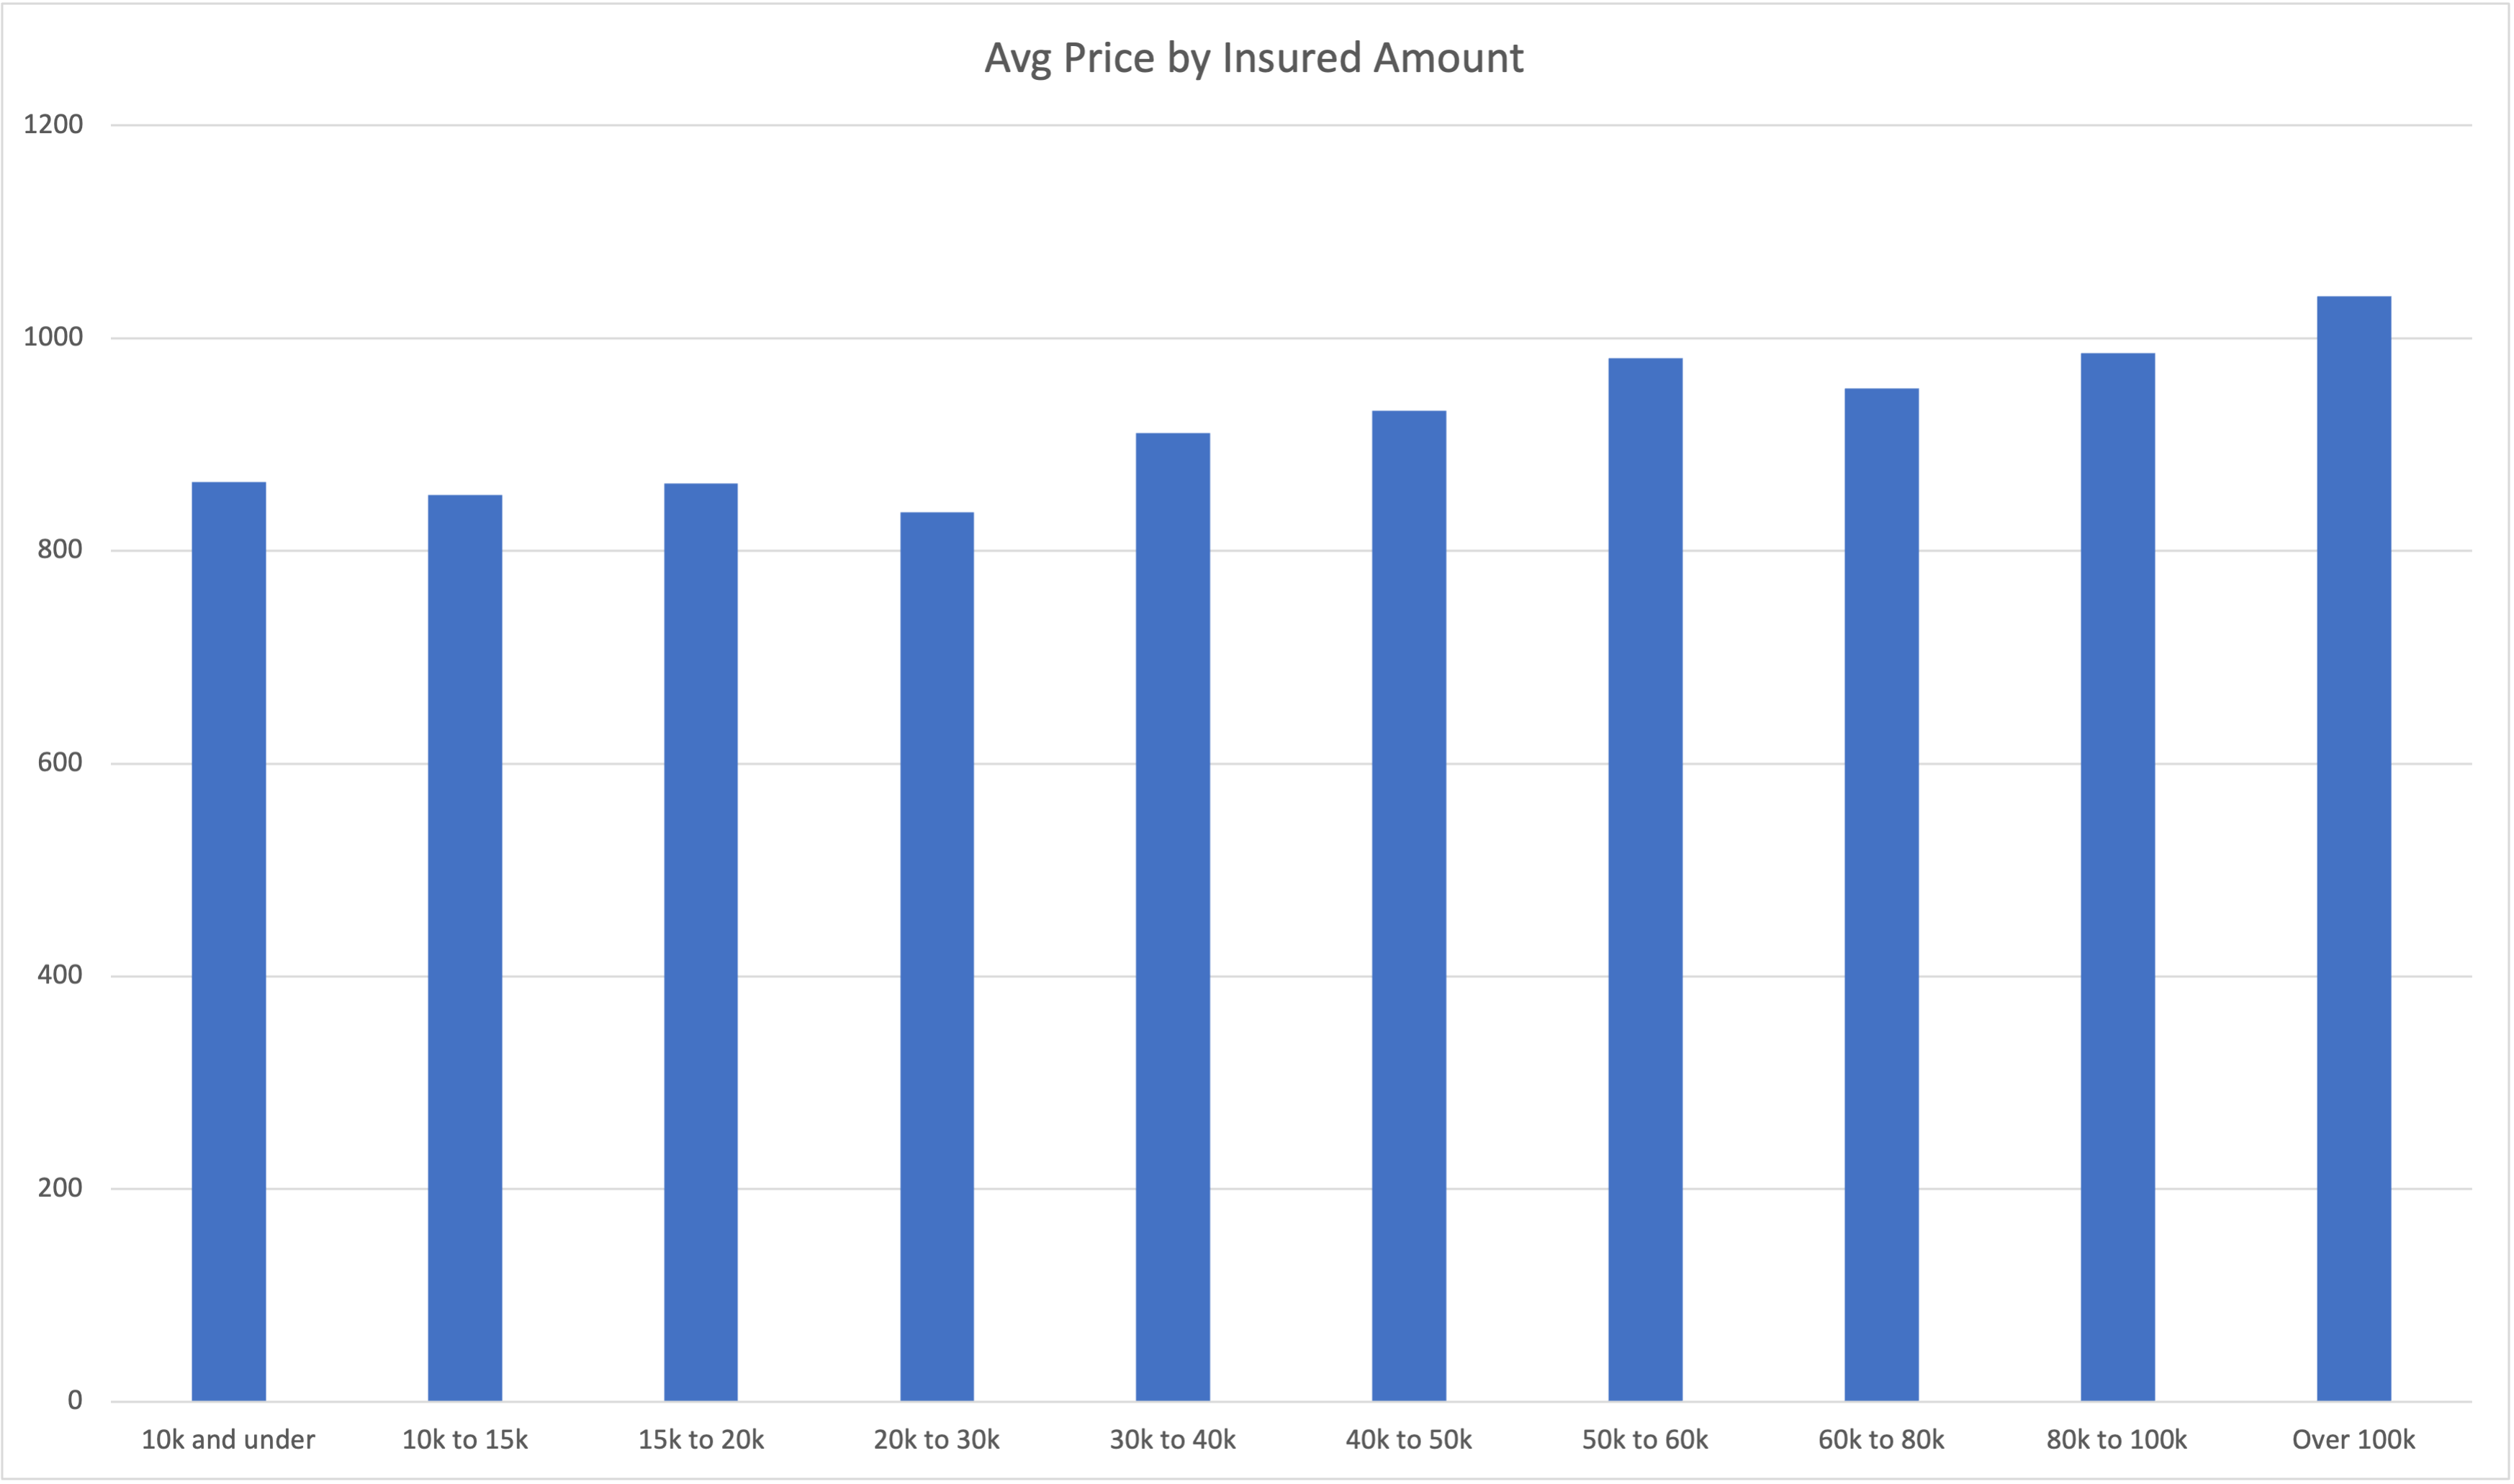

At a glance there seems to be a trend with a few outliers (20k to 30k, 40k to 50k, and 60k to 80k). 

Let's truncate the y axis for illustrative purposes. 

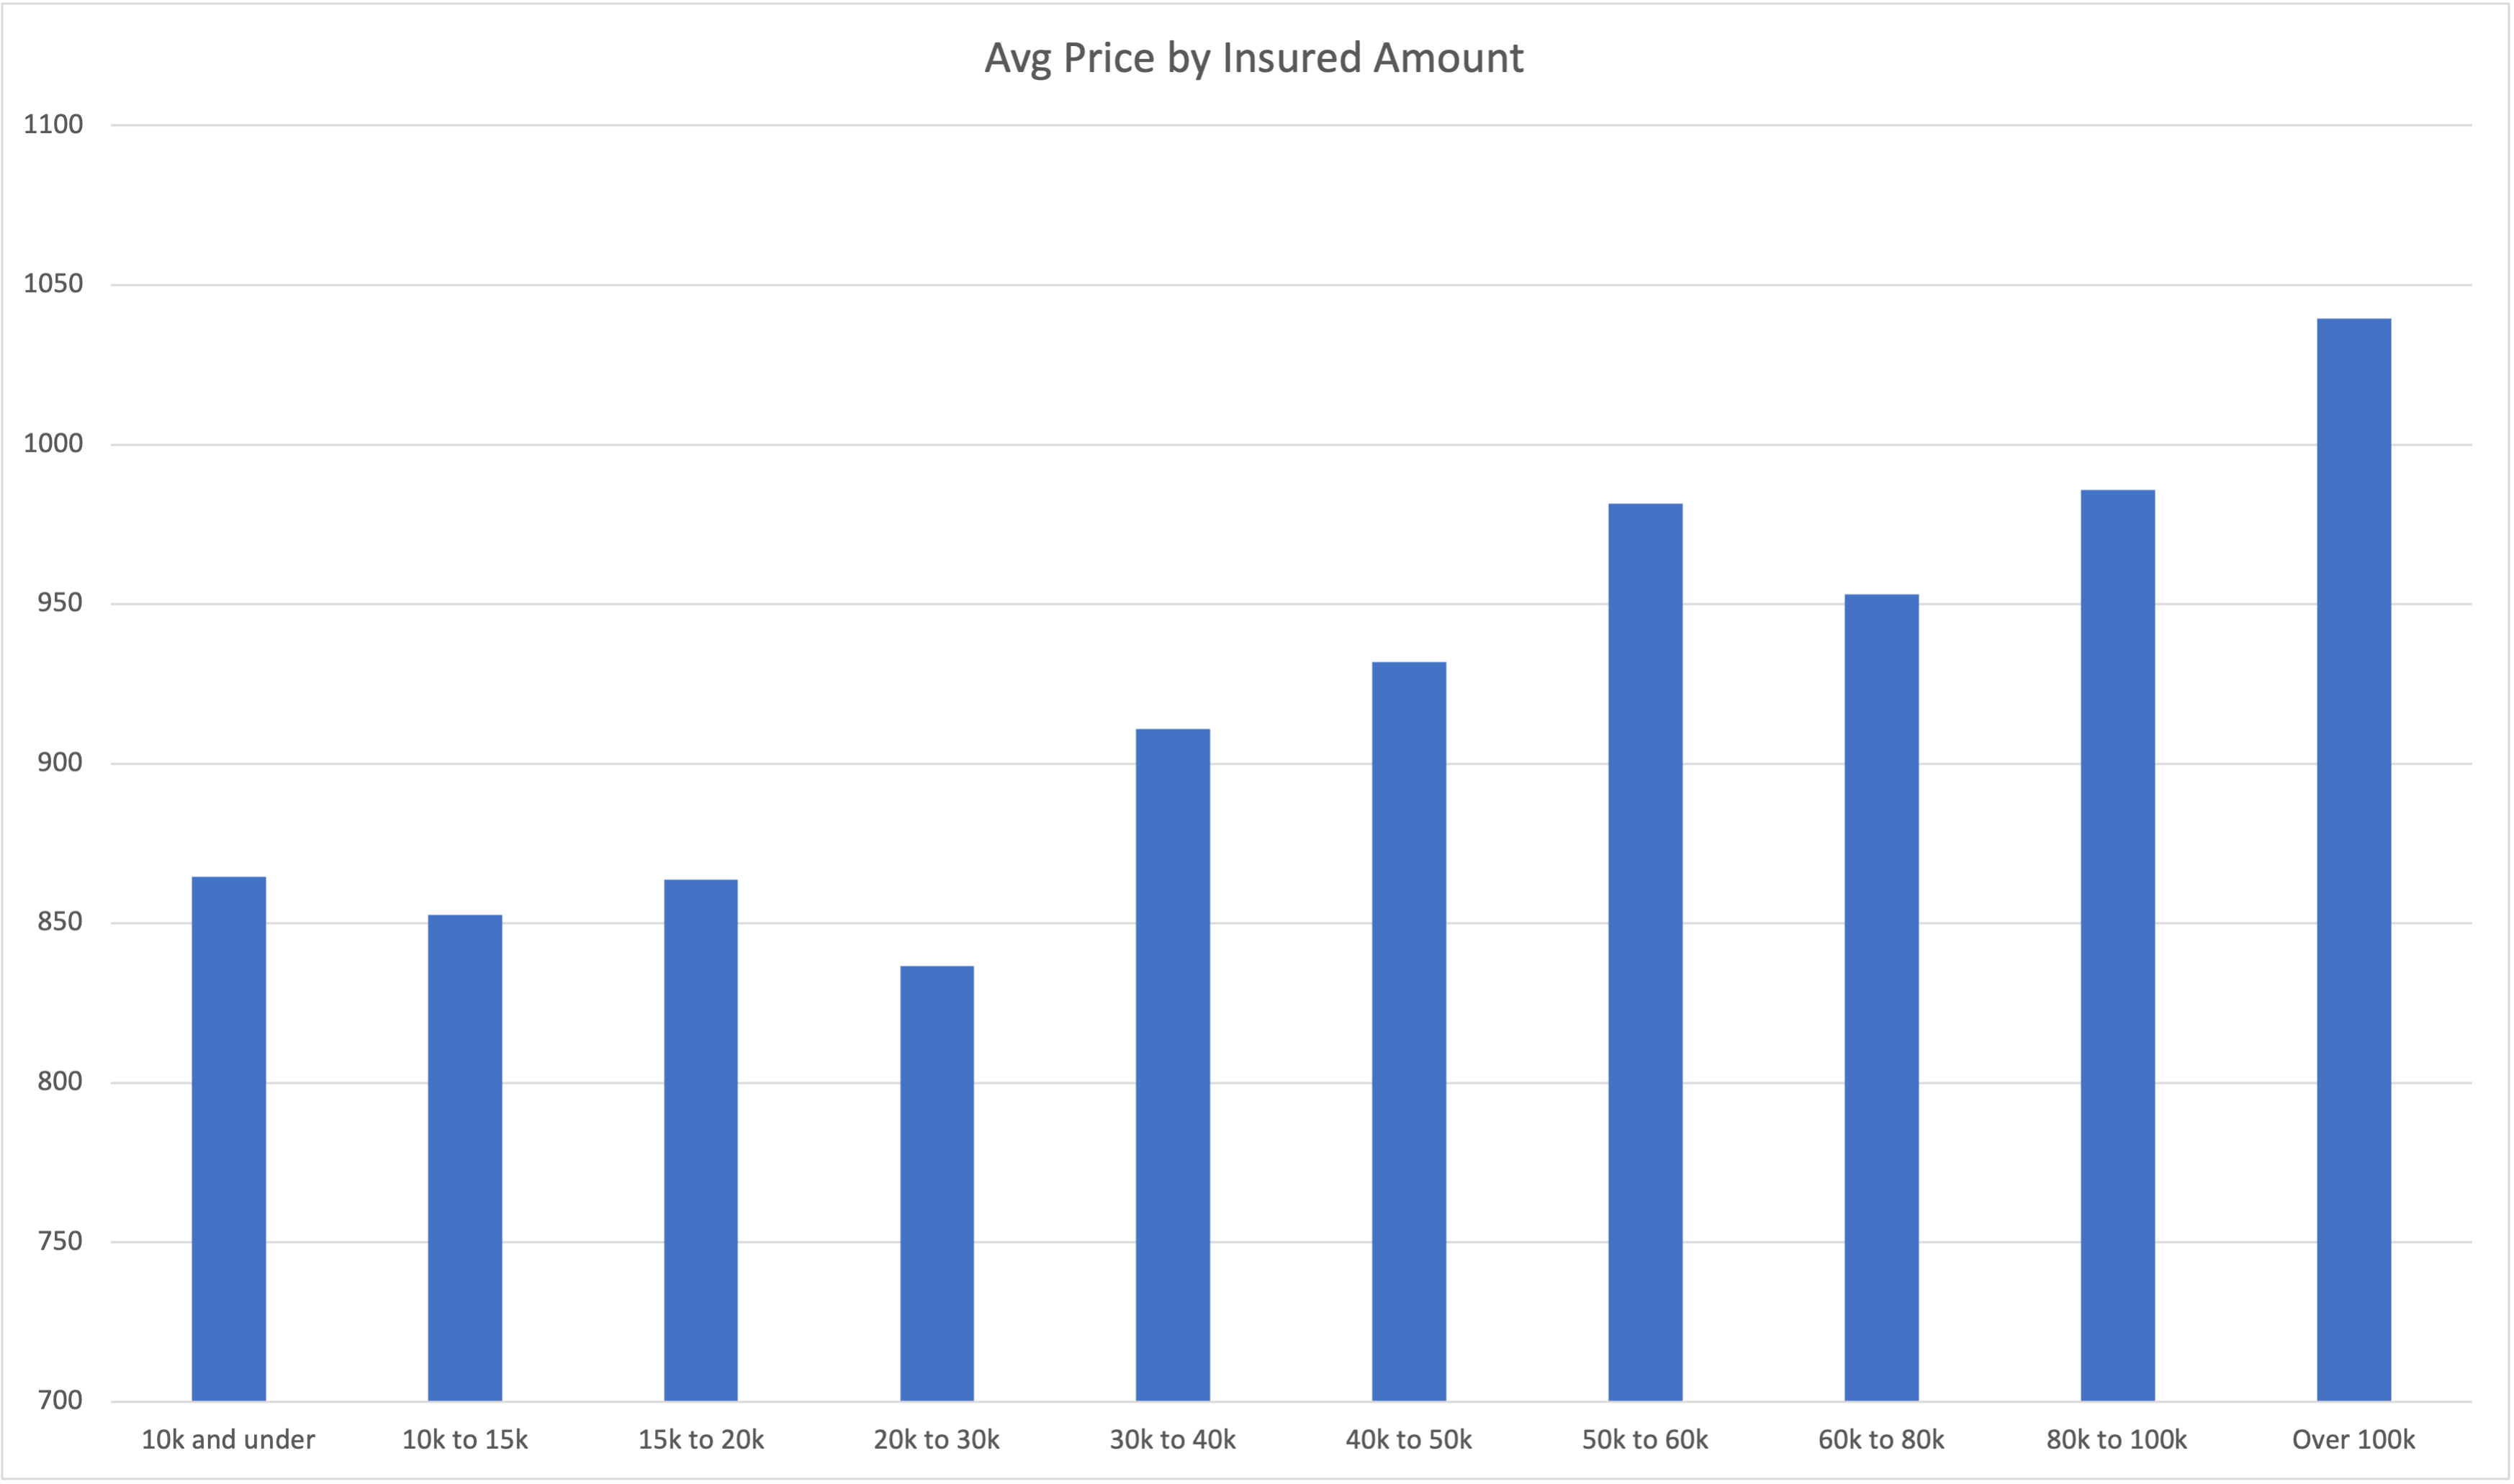


The highest insured amount, over 100k has an average quoted price of £1039, while the lowest, has an average quoted price of £847. 

#### Influence of insured amount on average price

Quotes for the highest insured amount, are 22.2% higher than quotes for the lowest insured amount thus confirming our hypothesis, and allows us to conclude that **insured amounts have an influence on quoted price.**

### Investigating excess requested
If there is a correlation, we'd expect that the lower the excess requested, the higher the quoted price, and vice versa. 

In [10]:
%%sql
--Grouping average price by excess requested. Count incl
SELECT excess_requested, AVG(adjusted_price), COUNT(*)
FROM insurance_joined_data
GROUP BY excess_requested;

Running query in 'sqlite:///urban_jungle_sample_data.db'

excess_requested,AVG(adjusted_price),COUNT(*)
0,902.2923181509177,1471
50,899.3421052631579,456
100,907.8846394984326,1595
150,897.1988472622478,694
200,908.3291592128802,559
250,909.7426796805679,4508
300,935.875,192
350,879.606936416185,173
400,936.8,60
450,966.6666666666666,9


As a chart, let's explore this relationship:

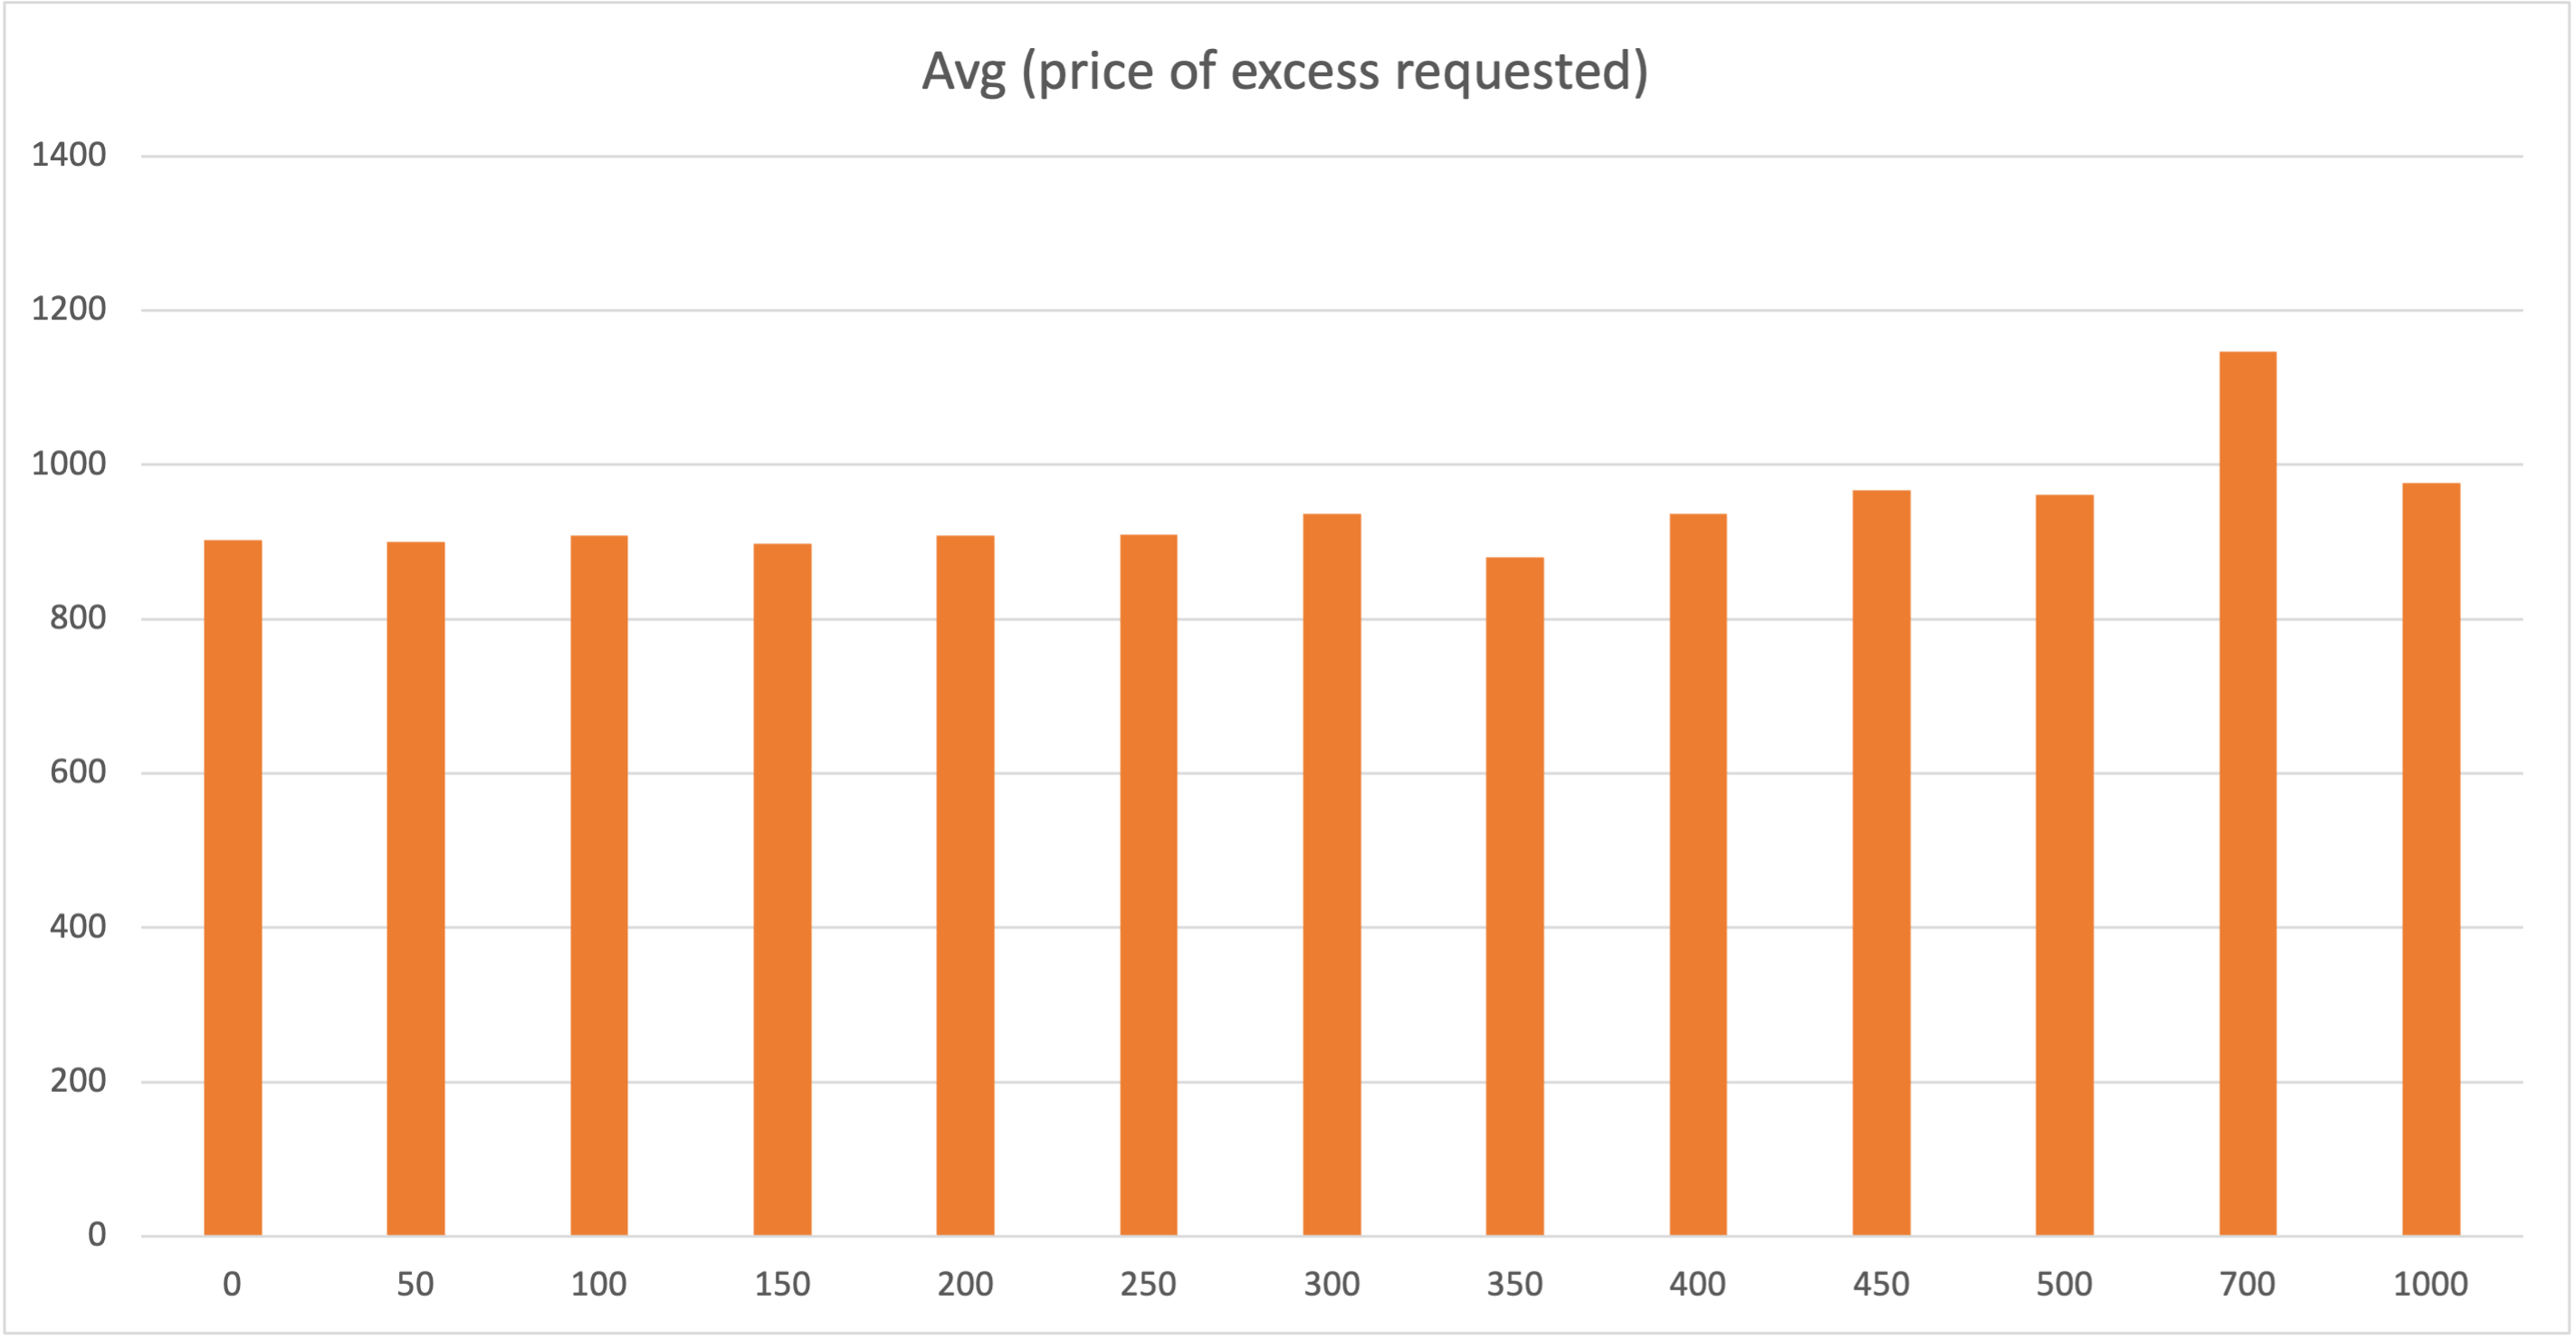

Zoomed out, there seems to be little correlation between the excess requested and the average price.

Let's zoom in on the axis a bit, just to try and see if there is a trend.

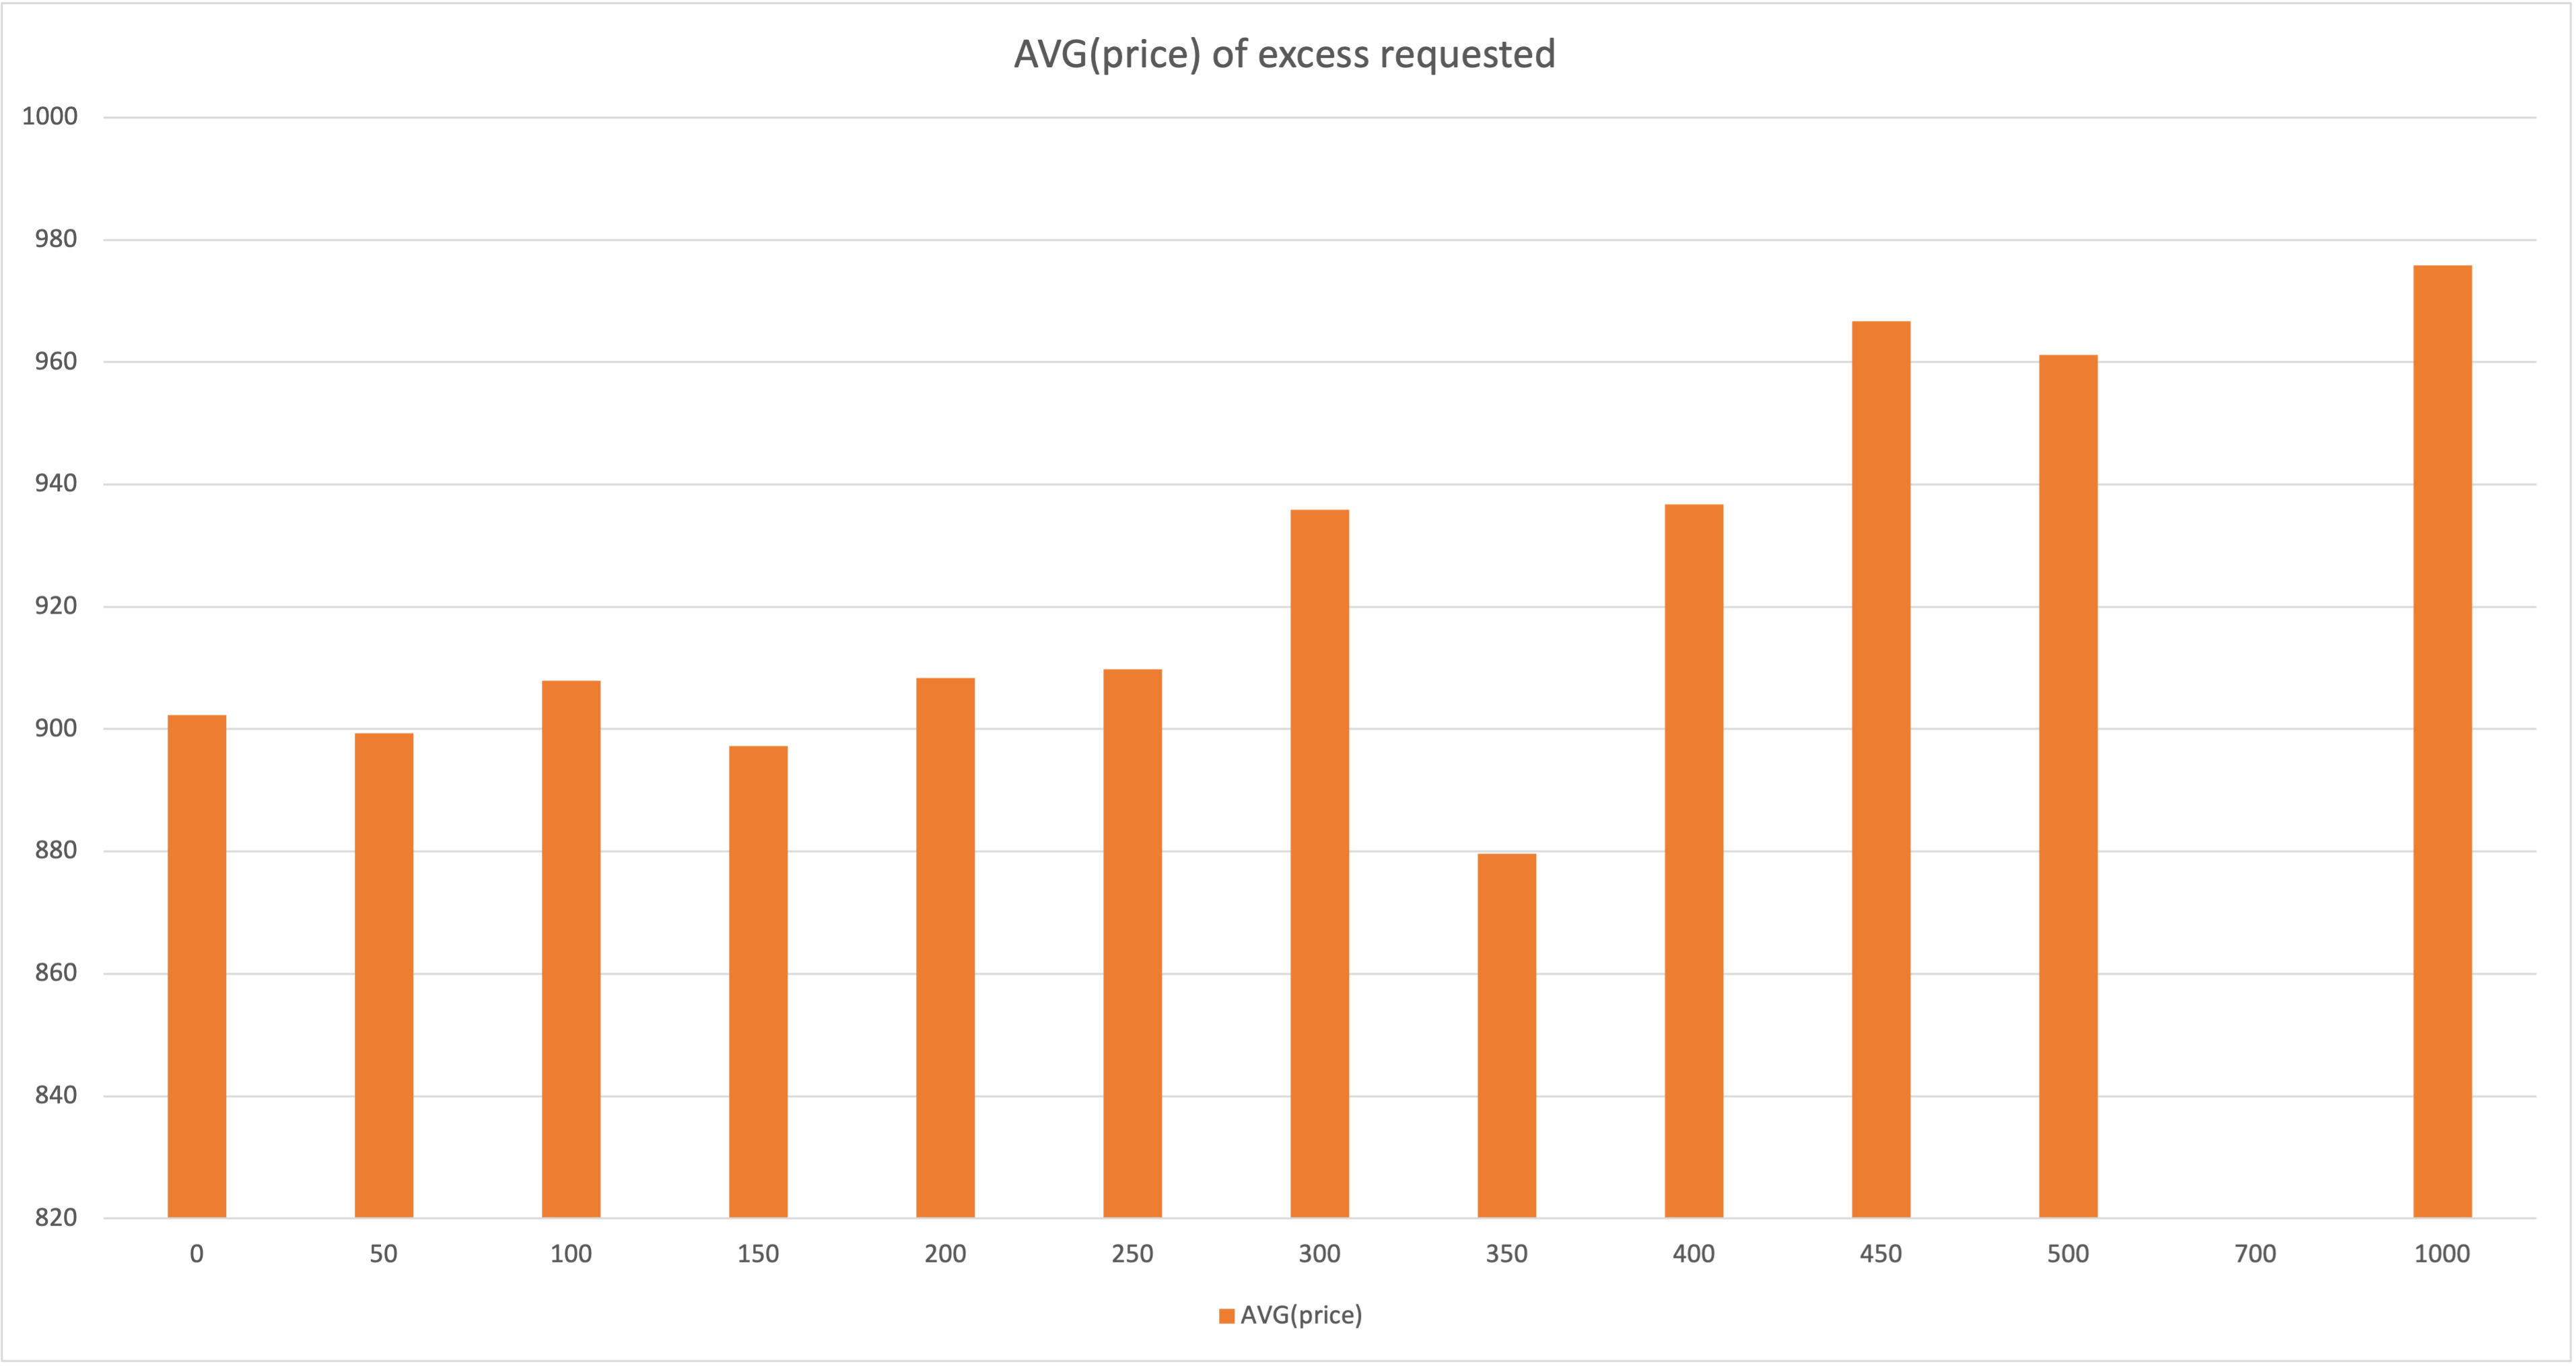

While there's barely a trend line (the £700 value was taken out, as it's an anomalously high value, with a sample size of 2), if anything it is the *opposite* of what we hypothesised. The higher the excess, the higher the quoted price. 


The highest excess, at £450 has an average quoted price of £967, which is 7% higher than the lowest excess (£0) which has an average quoted price of £902. This number is less than a percentage point different from the overall average quote.

#### Influence on excess requested on average price

Thus, we can conclude the excess has a **low influence on the quoted price**, and possibly **no influence on quoted price** as it defies the hypothesis, and weakly.

### Investigating previous claim count
If there is a correlation we'd expect that the higher the claim count, the higher the quoted price. However, there is only data on previous claims for 27% of the sample data, so it will be hard to make solid conclusions with this. 

Hypothesis: claim counts of 1 will have higher average quotes than claim counts of 0. 

In [5]:
%%sql
SELECT previous_claim_count, AVG(adjusted_price), COUNT(*)
FROM insurance_joined_data
GROUP BY previous_claim_count;

Running query in 'sqlite:///urban_jungle_sample_data.db'

previous_claim_count,AVG(adjusted_price),COUNT(*)
0,909.8177399756987,2469
1,913.4906832298136,322
,908.0349563046192,7209


A quick glance at the numbers shows that while claim counts of 1, are higher than claim counts of 0 and no data, it's by a small margin. 

Claim counts of 1 have an average quoted price of £913, which is 0.5% higher than claim counts of 0, or those of no data. 

#### Influence of previous claim count on average quoted price

The previous claim count has a **low influence on the quoted price**. 

### Investigating number of bedrooms
Hypothesis is that the higher the number of bedrooms, the higher the average quoted price. 

In [7]:
%%sql
SELECT number_bedrooms, AVG(adjusted_price), COUNT(*)
FROM insurance_joined_data
GROUP BY number_bedrooms;

Running query in 'sqlite:///urban_jungle_sample_data.db'

number_bedrooms,AVG(adjusted_price),COUNT(*)
1,736.2098360655738,305
2,793.1322115384615,1664
3,877.4913907284769,4530
4,987.3748584371461,2649
5,1096.1286713286713,715
6,1227.4594594594594,111
7,1240.8,20
8,1134.0,4
10,1134.0,2


A quick look a the count, shows we're going to suffer from the "tyranny of small samples", but seeing as houses with more than 7 bedrooms are rare, anyway, this isn't going to be much of a problem. We'll focus our investigation on dwellings with 1-5 bedrooms.

Let's look at those visually.

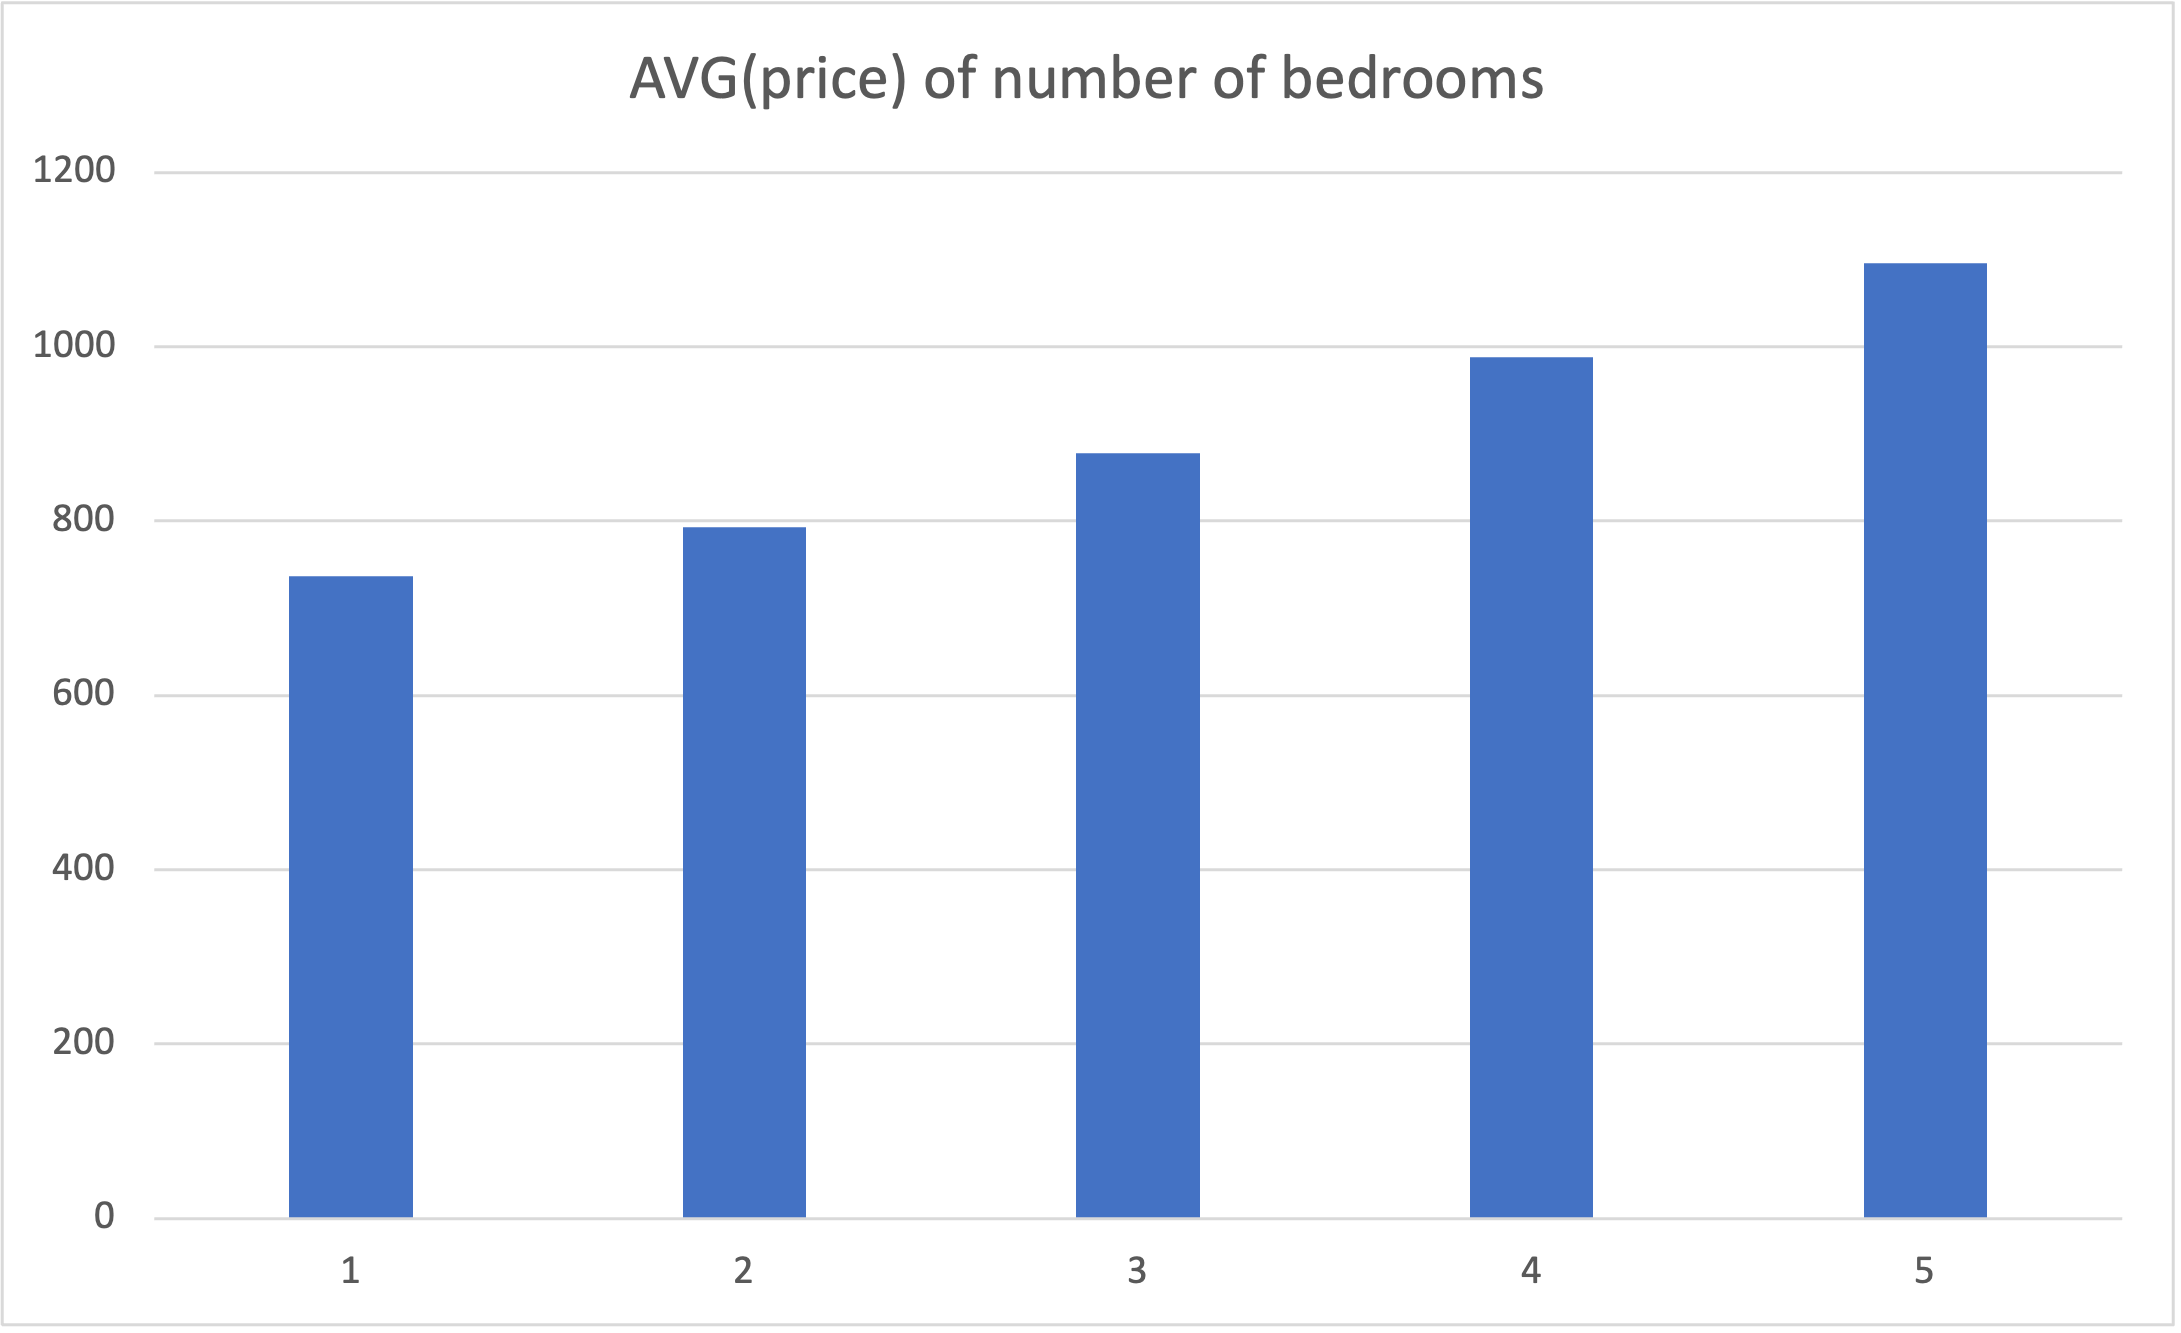

Visually we can see a correlation. The more bedrooms there are, the higher the average quote. 

The average quoted price for dwellings with 5 beds are £1096 which is **49%** higher than the quoted price for 1 beds at £736. They deviate from the overrall average quote of £909 by 21% and 19% respectively. 

#### Influence of number of bedrooms
We can conclude that the influence of the number of bedrooms **has the highest influence on the average quoted price** we've looked at so far. 

### Investigating number of bathrooms
Hypothesis is that the more bathrooms, the higher the quoted price. 

There will be small sample sizes for the larger bathroom numbers, so we'll cut those off in our subsequent analysis. 

In [8]:
%%sql
SELECT number_bathrooms, AVG(adjusted_price), COUNT(*)
FROM insurance_joined_data
GROUP BY number_bathrooms;

Running query in 'sqlite:///urban_jungle_sample_data.db'

number_bathrooms,AVG(adjusted_price),COUNT(*)
0,794.6666666666666,9
1,817.0552984165652,4105
2,914.6969225986944,3217
3,1016.7319636884854,2093
4,1106.8993288590605,447
5,1215.875,96
6,1228.1538461538462,26
7,1526.4,5
9,1680.0,1
10,1992.0,1


(Bathrooms of 0??? Either human error, or wow, I wouldn't want to live in that house!)

We'll focus our analysis on houses with 1-4 bathrooms. Let's look at it visually. 

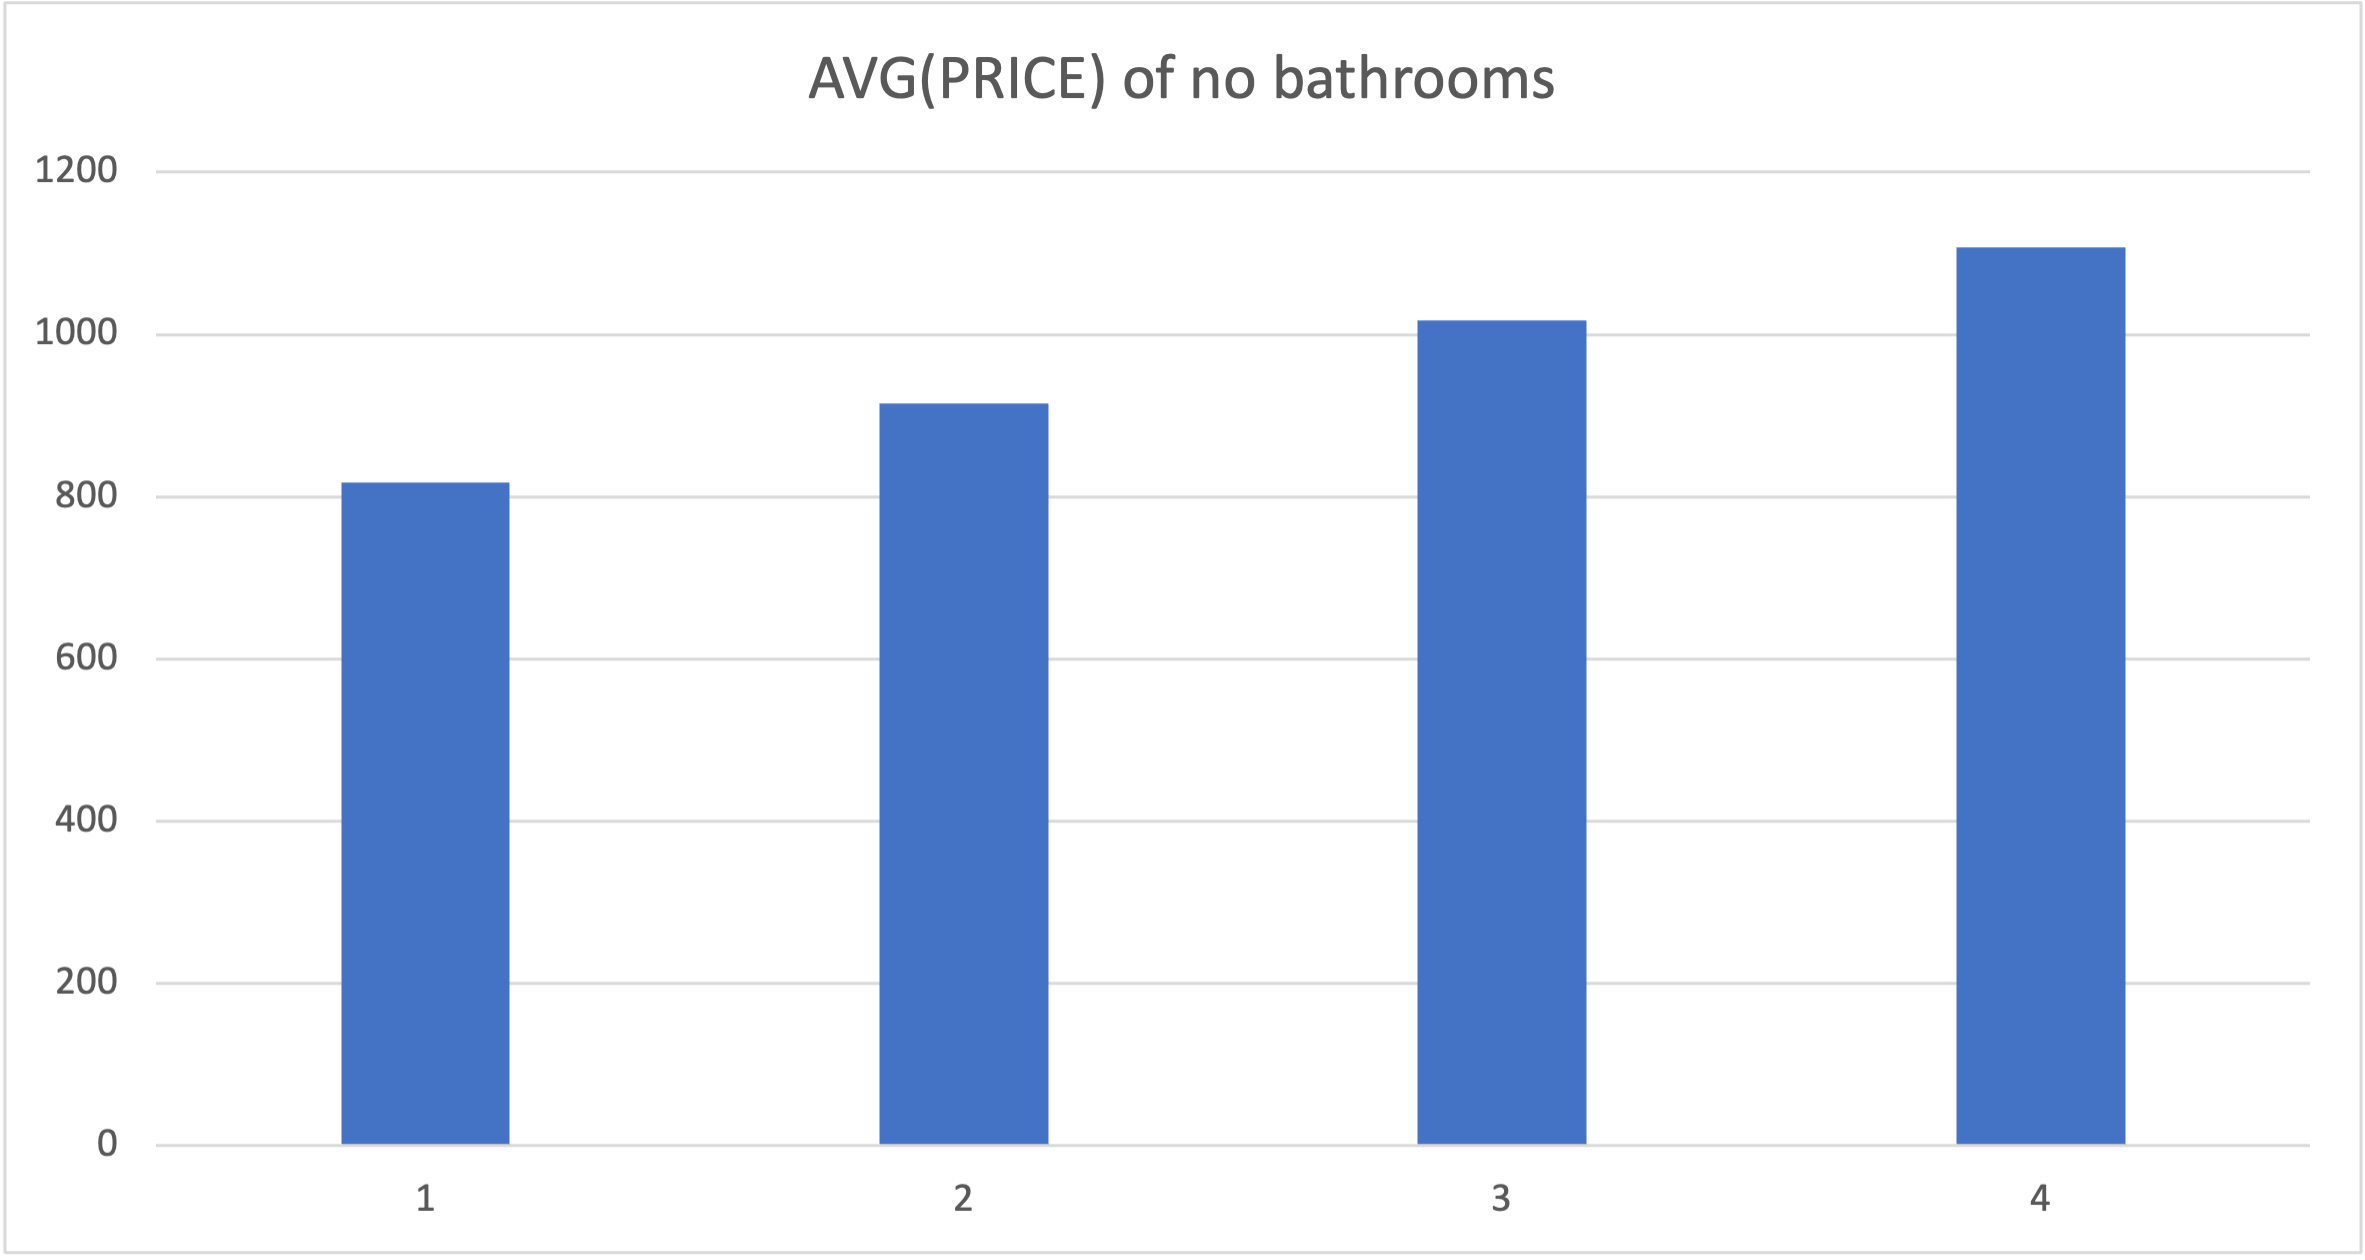

There is a visual correlation confirming our hypothesis. The average quoted price is higher the more bathrooms there are. 

Looking at the spread of the data, the highest average quote of 4 bathrooms at £1107 is 35.4% higher than the lowest average quote, at £817.

Compared to the overall average price of £909, they deviate by 22% and 10% respectively. 

#### Influence of number of bathrooms
The number of bathrooms has the **second largest influence** on average quoted prices, in our exploratory alysis so far. 

### Wildcard investigations
These are wildcard investigations just to see if something surprising comes up. 

#### Payment frequency


We've already looked at the payment frequency, when answering question one. 

| payment_frequency | AVG(adjusted_price) |
| ----------------- | ------------------- |
| annual            | 918.1299103000309   |
| monthly           | 891.3073005093379   |

Quoted prices are a little bit higher for annual payments, than monthly payments. But these are low amounts. Annual payments are 1% higher than the average price of £909, and monthly payments are 2% lower the average price.

**Low influence on quoted price**

#### Partner



A quick query grouping the average price by partner

In [9]:
%%sql
SELECT partner, AVG(adjusted_price), COUNT(*)
FROM insurance_joined_data
GROUP BY partner;

Running query in 'sqlite:///urban_jungle_sample_data.db'

partner,AVG(adjusted_price),COUNT(*)
BuyYourInsurance,910.2414905051953,2791
CompareTheIndustry,908.3164324984729,6548
QuantumPartners,905.2465960665658,661


Partnered average prices deviate less than 0.5% from the average price of £908.65. 

It's thus safe to say, there is **little to no influence of partners on the average quoted price.** 

### Explanatory analysis and Answer to Question 2

Our initial hypothesis was that these variables will influence the average price, in this order, ranging from the highest to lowest. 

1. Insured amount
2. Excess requested
3. Previous claim count
4. Number of bedrooms
5. Number of bathrooms

Our hypotheses proved to be incorrect. Instead, these two have the greatest influence on the quoted price:

1. Number of bedrooms. 
2. Number of bathrooms. 

#### Number of bedrooms. 
With average quoted prices of 5 beds being 21% higher than the average quoted price, and 1 beds being 19% lower than the average, the number of bedrooms affects the quote – the higher the number of bedrooms, the higher the quote. 

#### Number of bathrooms. 
Same holds for the number of bathrooms, however this has a marginally weaker affect on prices. 4 bathrooms have an average quoted price that is 22% higher than the average, but 1 bathrooms have a 10% quote that's lower than the average.

Next up, is the insured amount. 

#### Insured amount. 
While the highest insured amount of £100k+, has a quoted price of £1039, 14% higher than the average, the lowest amount of <£10k has an average price of £847, a 7% deviation from the average. 

There is a correlation, but it is weak. 

The spread between the lowest and highest amounts, is 20%, less than that for the number of bathrooms (35.4%) and less than half for the number of bathrooms (49%).

#### Other investigations
Other investigated variables showed low or no influence on quoted prices, with prices deviating by 2% from the average at most. 

The excess requested proved to have a very low, but *opposing* trend to what is expected. The higher the excess requested by customers, the higher the quotes they seemed to get. Suggesting that other variables play a larger role, and there is a hidden correlation between customers who ask for excesses and other, more influential variables. 

#### In summary
The number of bedrooms, and the number of bathrooms have the most affect on the quoted price. A high bedroom count, or high bathroom count, can yield quoted prices of 20% above the average. A low bedroom or low bathroom count can get quotes that are 10% lower than the average.



## Question 3 – If we only allow customers to purchase with no previous claims, what % eligbility would we have, based on the customers in the sample?

To answer this, we'll do a query looking at customers where we have data on previous claims. 

In [12]:
%%sql 
SELECT previous_claim_count, COUNT(*)
FROM insurance_joined_data
WHERE previous_claim_count = 0
OR previous_claim_count = 1
GROUP BY previous_claim_count;

Running query in 'sqlite:///urban_jungle_sample_data.db'

previous_claim_count,COUNT(*)
0,2469
1,322


There is a total of **2791** records that have previous claims data, roughly 28% of the sample. 

Looking at this data, if Urban Jungle were to only allow customers with no previous claims, then **88.46%** would be eligible.

### Answer to Question 3
**88.46% of customers will be eligible, based on the customers in the sample.**

## Question 4 – Does the data suggest we price differently based on which partner a customer comes through?

We touched on this in our exploratory analysis (when we did some wildcard analysis) in Question 2. But let's have a look at the data again. We'll look at the average price by partner. 

In [13]:
%%sql
SELECT partner, AVG(adjusted_price), COUNT(*)
FROM insurance_joined_data
GROUP BY partner;

Running query in 'sqlite:///urban_jungle_sample_data.db'

partner,AVG(adjusted_price),COUNT(*)
BuyYourInsurance,910.2414905051953,2791
CompareTheIndustry,908.3164324984729,6548
QuantumPartners,905.2465960665658,661


While there does seem to be, at first glance, a difference between prices based on partner (with QuantumPartners getting the lowest average quotes, at £905, compared to BuyYourInsurance's £910)...

Let's look at the tables in a different way. Let's look at the percentage difference from the average price. 

| partner            | percent difference from average price |
| ------------------ | ------------------------------------- |
| BuyYourInsurance   | 0.18%                                 |
| CompareTheIndustry | -0.04%                                |
| QuantumPartners    | -0.37%                                |

The data suggests that yes, there is a price difference, but it is *marginal*, at less than 0.4% difference from the average prices.

### Answer to Question 4
The data suggests that there is a **marginal** affect on prices, depending on the partner they come through, but it is very low, almost insignificant. 



## Question 5 – Suggest some improvements to the pricing process

Some caveats first. This analysis was limited. A top N and bottom N analysis was outside the scope of this project for instance. This was just a straightforward look at aggregate average prices, by cohort, isolating for one variable at a time. 

However the following suggestions:

### Improve the third_party data collection on previous claims

Only 28% of the sample size had data on previous claims. 

It is hard to make this variable play a part on pricing until there's more data coverage. 

After all, if customers with data on claim counts of 1, have higher claims than those that have no data. Then this penalises customers who have data from third parties more, rather than customers who have previous claim counts.

Also Urban Jungle could be pricing customers who have previous claim counts incorrectly, as they don't have the data, absorbing unnecessary risk. 

Once data coverge of this has reached a significant level, then claim counts can play a larger role in pricing.

### Make excesses play a larger role in pricing
At the moment, from investigating this sample, excess seems to play little to no role on pricing. Let's look at the average prices, grouped by excess, for 3 bedrooms and 1 bathroom (chosen for sample size quality, and to restrict variables). 

In [15]:
%%sql
SELECT excess_requested, AVG(adjusted_price), COUNT(*)
FROM insurance_joined_data
WHERE number_bedrooms = 3
AND number_bathrooms = 1
GROUP BY excess_requested;

Running query in 'sqlite:///urban_jungle_sample_data.db'

excess_requested,AVG(adjusted_price),COUNT(*)
0,840.9103448275862,290
50,820.448275862069,116
100,838.0682926829269,410
150,833.6507936507936,189
200,825.2307692307693,117
250,836.5991902834008,988
300,863.0,48
350,835.6363636363636,11
400,837.6,10
450,744.0,2


We'll look at only excesses of 0 to 250, to avoid low sample noise. 

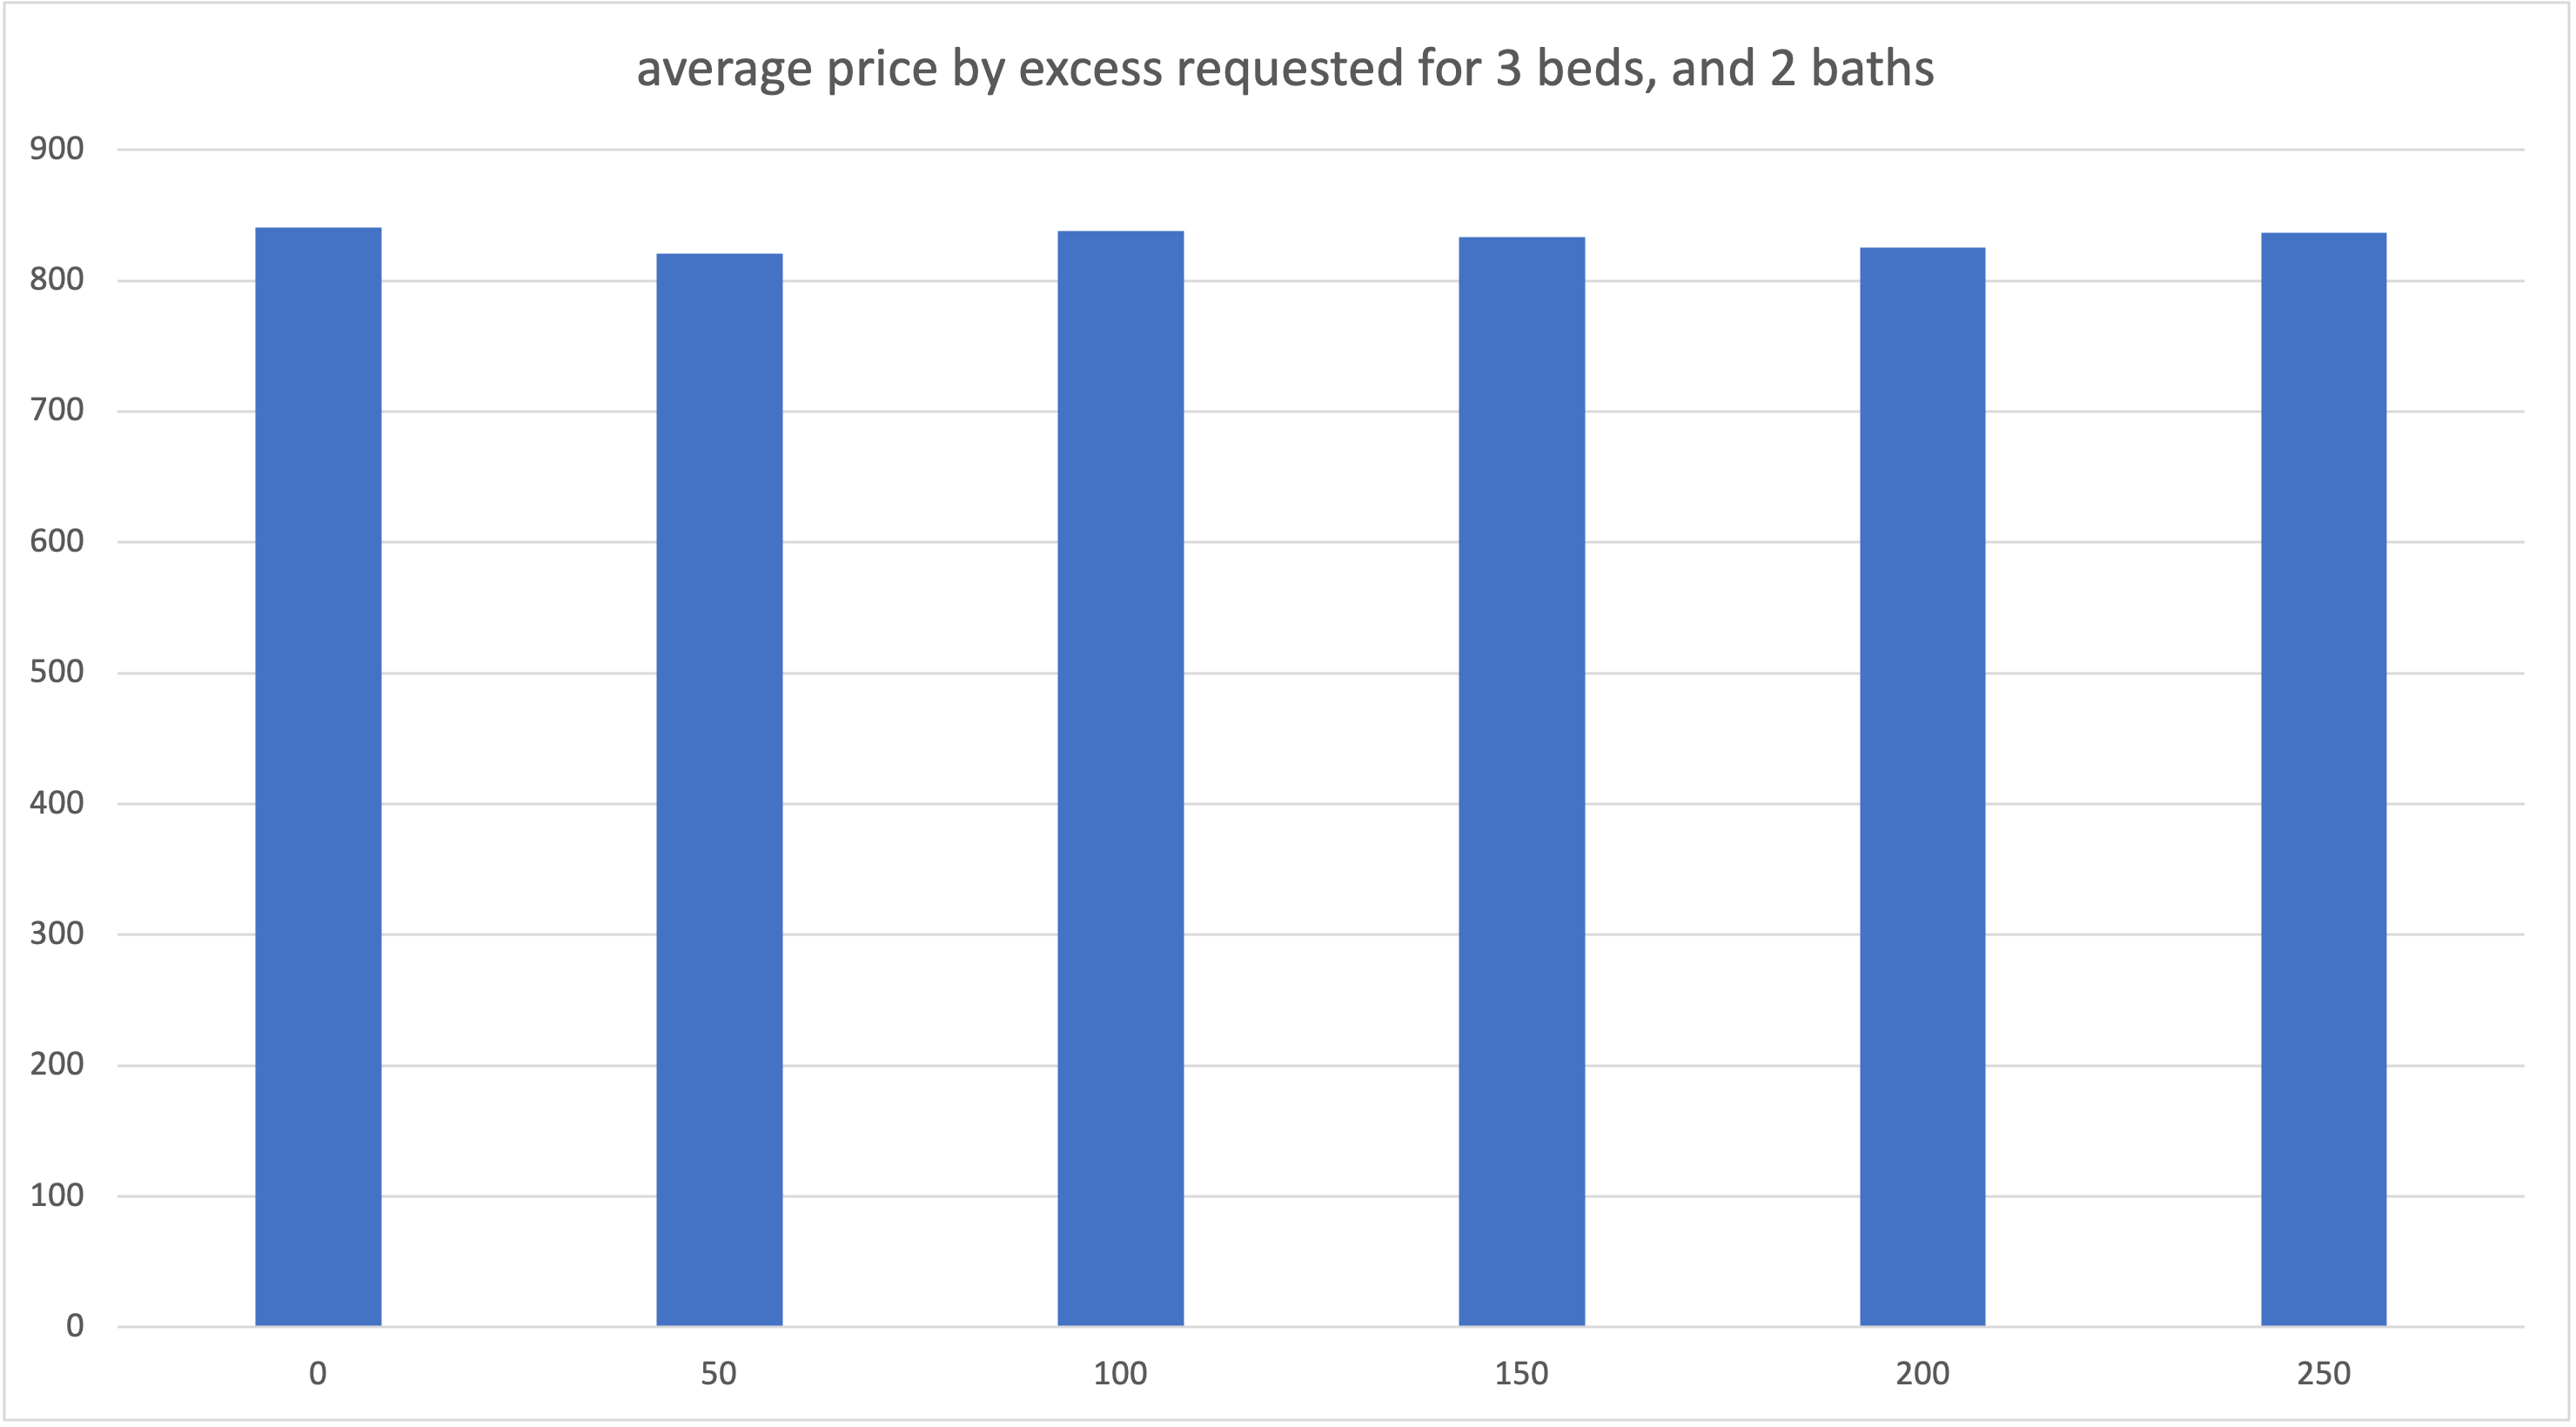

There is very little variation in the average prices. Let's truncate the axis to confirm this. 

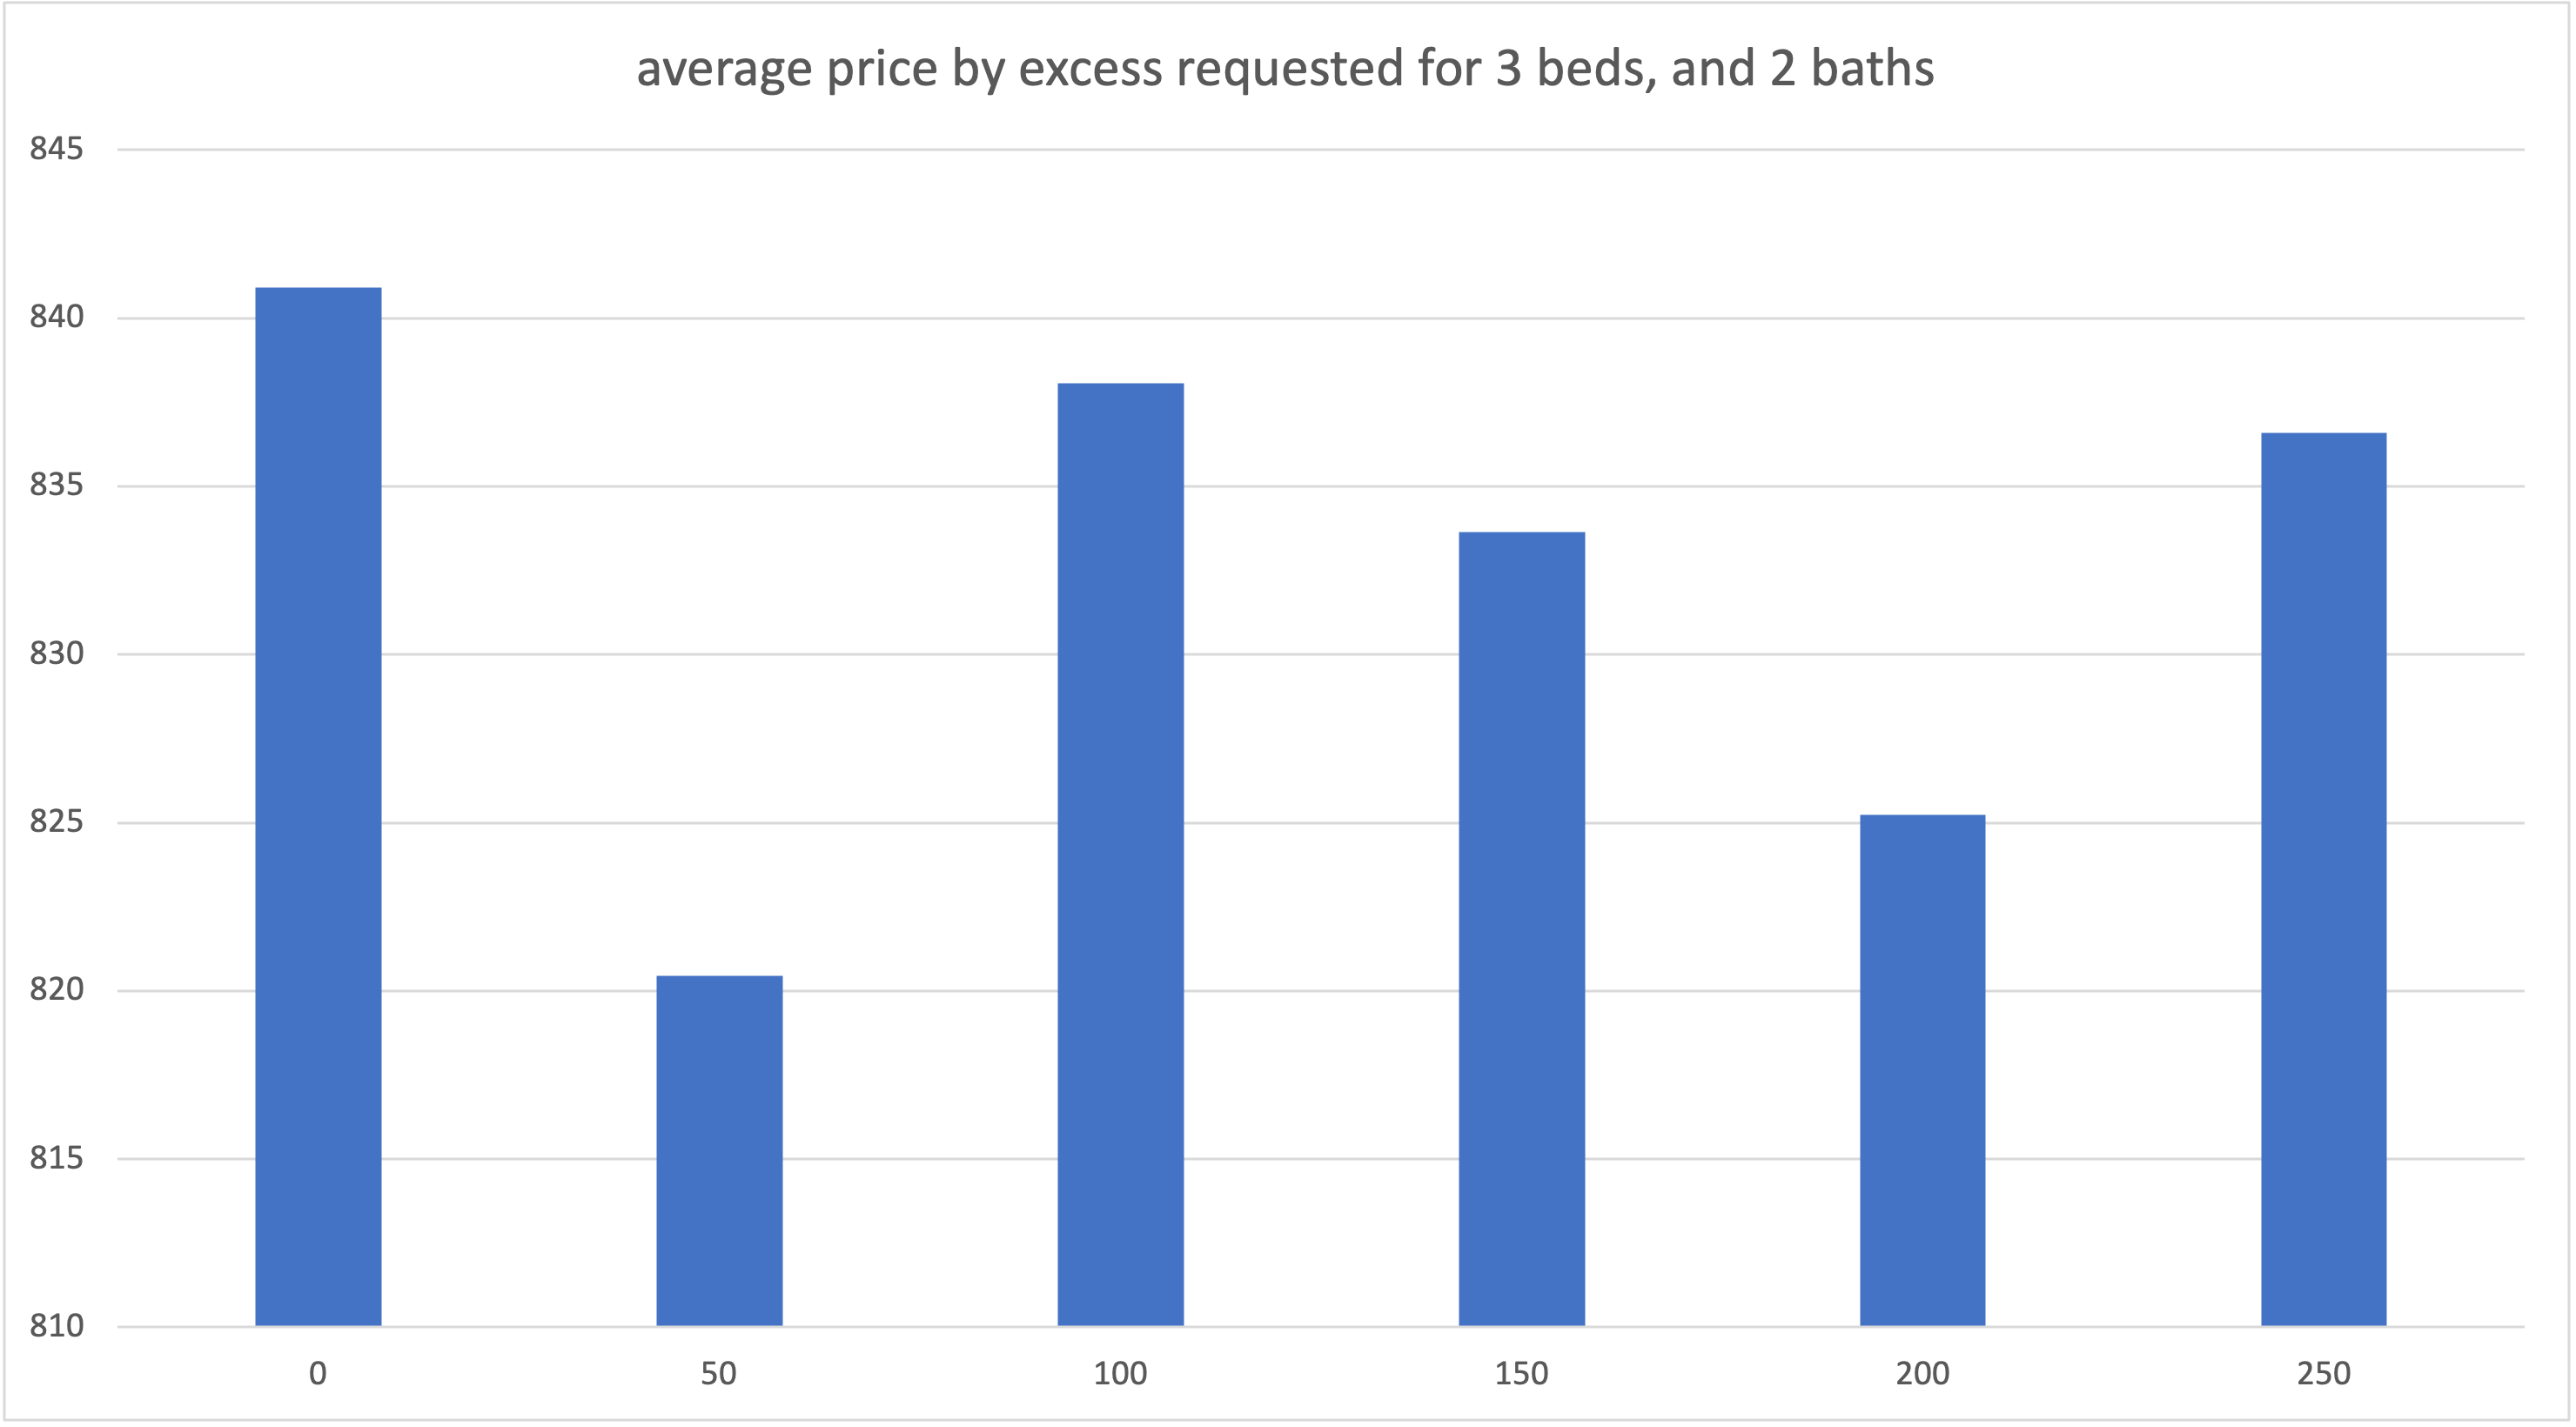

When we zoom in, and truncate the y axis, there seems to be little pattern to the excess and the average price. The excess of £250 has a higher quote than the excess of £50. 

Since excess is the principle method customers use to lower their quotes (and demonstrate their risk appetite), this should play a larger role in pricing, unless other data shows that excesses play a weak role in claim counts.

### Weather and Nature risk factors

At the moment, there is no data on the home location being collected in the data sample. While, one needs to be careful to ensure there are no regional or socioeconomic biases at play in pricing, some areas of the nation are more prone to adverse weather events, than others. 

This should be reflected in the pricing methodology. 

### Fraud prevention

Insurance fraud was valued at a £1.1 billion cost to insurers in 2022. More methods to detect fraud up front should be used, and reflected in pricing. 

### Smartphone use

Inspired by solutions like Zego, smartphone use can be used as a pricing mechanism. For customers who opt-in, location tracking can be used to detect patterns of when residents are at home, and when they aren't. 

Incentives should be provided for this, while aligning to GDPR protocols. For customers who opt-in, and go on holiday for instance, they can choose to notify Urban Jungle or not via an app, that they're away, and precautions they've taken to ensure the safety of their home (e.g. security cams, or house-sitters). 

## Thank you

Thank you for reading this take home project, analysing sample data on pricing home insurance. 

I had a lot of fun doing this, and I can't wait to discuss the task, and the role in more detail. 

Thanks!

David Heasman